# 1. Import libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import ETFs as etfs

Total number of ETFs: 33


# 2. Read assets from csv file

In [2]:
data = pd.read_csv('../../dataProcessing/assets_filled.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)
display(data)


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,21.902443,6.246624,40.000000,42.619999,26.042212,22.380077,42.757008,12.307330,20.625574,14.720881,...,28.830000,100.450684,83.888573,317.519989,69.905655,42.300957,27.664722,34.591938,33.707809,6.78375
2012-01-04,21.902443,6.246624,40.000000,42.509998,26.165096,22.380077,42.757008,12.452251,20.587934,14.581520,...,28.389999,100.608261,82.891136,318.160004,70.114944,42.300957,27.328695,34.000530,33.888020,6.69750
2012-01-05,21.902443,6.246624,40.000000,41.509998,25.814005,22.380077,42.757008,12.290605,20.459967,14.412823,...,28.510000,100.876129,82.743668,313.359985,69.817871,42.300957,26.831099,34.319885,33.472149,6.68250
2012-01-06,21.902443,6.246624,40.000000,41.349998,25.919331,22.380077,42.757008,12.128960,20.249193,14.148770,...,27.910000,100.616127,83.396919,313.760010,69.392532,42.300957,26.462753,34.207520,33.070118,6.72625
2012-01-09,21.902443,6.246624,40.000000,42.189999,25.831558,22.380077,42.757008,12.167979,20.309414,14.207450,...,28.129999,100.860359,83.249390,312.640015,69.655830,42.300957,26.663073,34.089233,33.097832,6.69625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,38.276001,10.405000,100.550003,18.930000,14.140000,107.930000,56.490002,23.700001,41.509998,38.029999,...,29.959999,574.080017,88.790054,74.879997,129.030991,140.270004,71.730003,90.728004,74.690002,8.28750
2025-03-25,38.380001,10.440000,100.720001,18.770000,14.030000,107.330002,56.580002,23.809999,41.709999,38.380001,...,30.580000,575.460022,88.780167,74.820000,129.460007,140.479996,72.160004,89.709999,75.089996,8.14875
2025-03-26,37.854000,10.400000,98.169998,18.559999,14.110000,105.839996,56.080002,23.709999,41.380001,37.560001,...,30.530001,568.590027,88.196609,75.419998,130.250000,139.595001,71.139999,90.059998,74.410004,8.14500


In [3]:
binary_targets = pd.read_csv('../../dataProcessing/target_binary.csv', parse_dates=['Date'])
binary_targets.set_index('Date', inplace=True)

# 3. Splitting the dataset

In [4]:

dataset_size = len(data)
train_size = int(dataset_size * 0.8)
test_size = int(dataset_size * 0.1)
val_size = dataset_size - train_size - test_size

train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:train_size + val_size]
test_data = data.iloc[train_size + val_size:]

binary_targets_train = binary_targets.iloc[:train_size]
binary_targets_val = binary_targets.iloc[train_size:train_size + val_size]
binary_targets_test = binary_targets.iloc[train_size + val_size:]


# 4. Create rolling windows

In [5]:
def create_X_y(data,target_label, window_size):
    X, y, labels, first_prices = [], [], [], []
    print(len(data), window_size)
    for i in range(len(data) - window_size):
        window = data.iloc[i : i + window_size]
        first_value = window.iloc[0]
        normalized_window = window / first_value
        X.append(normalized_window.values.flatten()) 


        y_target = data.iloc[i + window_size]/ first_value
        y.append(y_target.values) 
        
        l = target_label.iloc[i+window_size]
        labels.append(l)
        
        first_prices.append(first_value)
        
    X = np.array(X)
    y = np.array(y)
    first_prices = np.array(first_prices)
    labels = np.array(labels)
        
    return X, y, first_prices, labels

window_size = 30

X_train, y_train, first_values_train, labels_train = create_X_y(train_data, binary_targets_train, window_size)
X_val, y_val, first_values_val, labels_val = create_X_y(val_data, binary_targets_val, window_size)
X_test, y_test, first_values_test, labels_test = create_X_y(test_data, binary_targets_test, window_size)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape, labels_train.shape, labels_val.shape, labels_test.shape



2726 30
342 30
340 30


((2696, 990),
 (2696, 33),
 (312, 990),
 (312, 33),
 (310, 990),
 (310, 33),
 (2696, 33),
 (312, 33),
 (310, 33))

In [6]:
rf = MultiOutputRegressor(
    RandomForestRegressor(
        random_state=42,
        criterion='squared_error',
        n_estimators=100,
        max_depth=10,
        min_samples_split=2,
        n_jobs=-1,
    ))

rf.fit(X_train, y_train)

,estimator,RandomForestR...ndom_state=42)
,n_jobs,None
,n_estimators,100
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0


In [7]:
Y_pred = rf.predict(X_test)
Y_pred_denorm = Y_pred * first_values_test

predicted_prices = pd.DataFrame(Y_pred_denorm, index=data.index[-len(Y_pred):], columns=data.columns)
predicted_prices.index = data.index[-len(predicted_prices):]
# predicted_prices["SPY"].plot()

In [8]:
# SUMMARY
y_test_denorm = y_test * first_values_test


mae = mean_absolute_error(y_test, Y_pred)
mse = mean_squared_error(y_test, Y_pred)
r2 = r2_score(y_test, Y_pred)
rmse = np.sqrt(mse)


print(f"Mean Absolute Error: {mae:.4f}" )
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error:{rmse:.4f}")
print(f"R² Score: {r2:.4f}")





Mean Absolute Error: 0.0095
Mean Squared Error: 0.0002
Root Mean Squared Error:0.0138
R² Score: 0.9366


In [9]:
# display(labels_test)

In [10]:
# data

In [11]:
# predicted_prices

In [12]:
index_series = data.index[train_size + val_size + window_size:]

y_test_shift = data[train_size + val_size + window_size - 1: -1]
y_test_shift_index = data.index[train_size + val_size + window_size-1: -1]

y_test_shift_df = pd.DataFrame(y_test_shift, index=y_test_shift_index, columns=data.columns)
y_test_shift_array = y_test_shift_df.values


predicted_directions = (Y_pred_denorm > y_test_shift_array).astype(int)
predicted_directions_df = pd.DataFrame(predicted_directions, index=index_series, columns=data.columns)
# display(predicted_directions_df)


In [13]:
from sklearn.metrics import accuracy_score

actual_flat = labels_test.flatten()
predicted_flat = predicted_directions_df.to_numpy().flatten()

accuracy = accuracy_score(actual_flat, predicted_flat)

print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.5097


In [14]:
y_test_denorm.shape

(310, 33)

y_test_denorm shape: (310, 33)


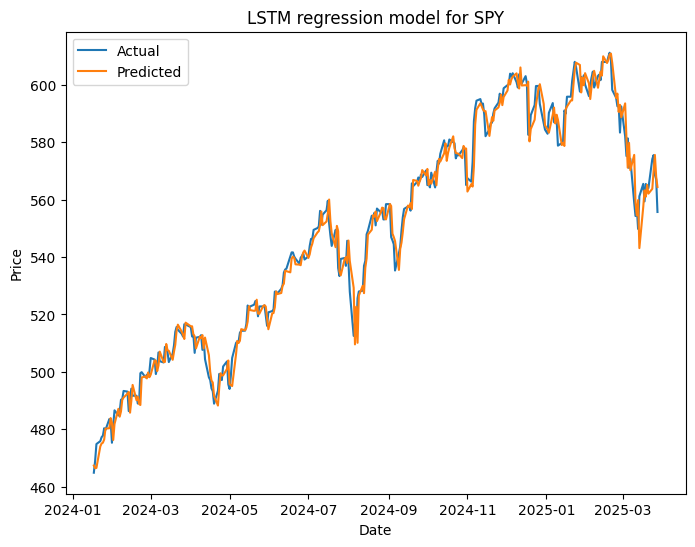

In [15]:
y_test_denorm = y_test * first_values_test
print(f"y_test_denorm shape: {y_test_denorm.shape}")
y_test_denorm= y_test_denorm[-test_size:]
y_actual = pd.DataFrame(y_test_denorm, index=data.index[-test_size+window_size::], columns=data.columns)
# display(predicted_prices)
ticker_name = 'SPY'

plt.figure(figsize=(8,6))
plt.plot(y_actual[ticker_name], label='Actual')
plt.plot(predicted_prices[ticker_name], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'LSTM regression model for {ticker_name}')
plt.legend()
plt.show()


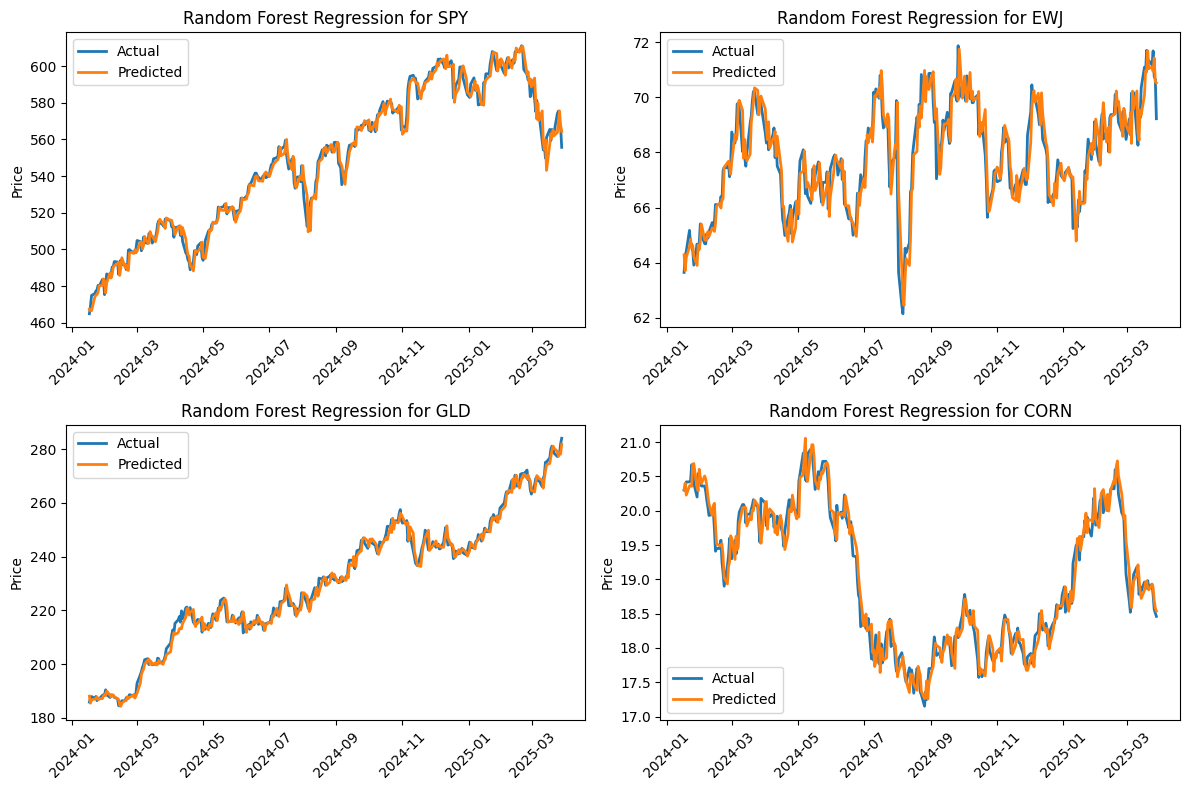

In [16]:
ticker_name = ['SPY', 'EWJ', 'GLD', 'CORN'] 
num_plots = len(ticker_name)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols


fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
axes = axes.flatten()  

for i, ticker in enumerate(ticker_name):
    ax = axes[i]
    ax.plot(y_actual[ticker], label='Actual', linewidth=2)
    ax.plot(predicted_prices[ticker], label='Predicted', linewidth=2)
    ax.set_title(f'Random Forest Regression for {ticker}')
    ax.set_ylabel('Price')
    ax.tick_params(axis='x', rotation=45)

    ax.legend()

for j in range(len(ticker_name), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
